# dNBR with Landsat


As discussed in the previous lesson, you can use dNBR to map the extent and
severity of a fire. In this lesson, you learn how to create NBR using
Landsat data.

You calculate dNBR using the following steps:

1. Open up pre-fire data and calculate *NBR*
2. Open up the post-fire data and calculate *NBR*
3. Calculate **dNBR** (difference NBR) by subtracting post-fire NBR from pre-fire NBR (NBR pre - NBR post fire).
4. Classify the dNBR raster using the classification table.


## Calculate dNBR Using Landsat Data

First, import your Python libraries.


In [17]:
import numpy as np
from glob import glob
import os

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask

import geopandas as gpd
from shapely.geometry import mapping, box

import earthpy as et
import earthpy.spatial as es

sns.set_style('white')

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

To calculate difference Normalized Burn Ratio (dNBR), you first need to calculate NBR for the pre and post fire data. This ofcourse presumes that you have data before the area was burned and after of from the same remote sensing sensor. Ideally this data also does not have clouds covering the fire area.

Open up and stack the Landsat post-fire data.

In [2]:
# Import and stack post fire Landsat data

all_landsat_bands = glob(
    "data/cold-springs-fire/landsat_collect/LC080340322016072301T1-SC20180214145802/crop/*band*.tif")

landsat_post_fire_path = "data/cold-springs-fire/outputs/landsat_post_fire.tif"

es.stack_raster_tifs(all_landsat_bands,
                     landsat_post_fire_path)

# You are not cropping the data in this lesson so you can just use .read()
with rio.open(landsat_post_fire_path) as src:
    landsat_post_fire = src.read(masked=True)
    landsat_post_meta = src.profile
    landsat_post_bounds = src.bounds
    landsat_extent = plotting_extent(src)


# Open fire boundary layer and reproject it to match the Landsat data
fire_boundary_path = "data/cold-springs-fire/vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp"
fire_boundary = gpd.read_file(fire_boundary_path)


# If the CRS' are not the same be sure to reproject
fire_bound_utmz13 = fire_boundary.to_crs(landsat_post_meta['crs'])

Next, you can calculate NBR on the post fire data. Remember that NBR uses different bands than NDVI but the calculation formula is the same. For landsat 8 data you will be using bands 7 and 5. And remember because python starts counting at 0 (0-based indexing), that will be bands 6 and 4 when you access them in your numpy array. 

Below the `es.normalized_diff()` function is used to calculate NBR. You can also calculate NBR like you did NDVI with raster math :

```
landsat_postfire_nbr = (
    landsat_post_fire[4]-landsat_post_fire[6]) / (landsat_post_fire[4]+landsat_post_fire[6])
```

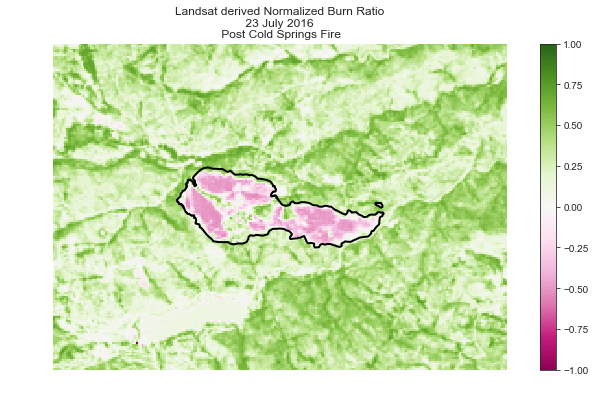

In [3]:
# Calculate NBR & plot
landsat_postfire_nbr = es.normalized_diff(
    landsat_post_fire[6], landsat_post_fire[4])

fig, ax = plt.subplots(figsize=(12, 6))
ndvi = ax.imshow(landsat_postfire_nbr,
                 cmap='PiYG',
                 vmin=-1,
                 vmax=1,
                 extent=landsat_extent)

fire_bound_utmz13.plot(ax=ax, color='None',
                       edgecolor='black', linewidth=2)

fig.colorbar(ndvi)
ax.set(title="Landsat derived Normalized Burn Ratio\n 23 July 2016 \n Post Cold Springs Fire")
ax.set_axis_off()
plt.show()

Next, calculate NBR for the pre-fire data. Note that you will have to download the data that is being used below from Earth Explorer following the lessons in this tutorial series. 

Also note that you will need to clip or crop the data so that you can subtract the post fire data from the pre fire data. The code to do this is hidden but you did this last week so you should know what to do!


In [4]:
# Create clip extent using the post fire data
landsat_clip = mapping(box(*landsat_post_bounds))

path_landsat_pre_st = 'data/cold-springs-fire/outputs/landsat_pre_st_hw.tif'

# Open and crop landsat pre-fire data
with rio.open(path_landsat_pre_st) as landsat_pre:
    # crop landsat data using the fire boundary reprojected
    landsat_pre_crop, landsat_pre_meta = es.crop_image(
        landsat_pre, [landsat_clip])


# Are the two rasters the same size?
landsat_pre_crop.shape == landsat_post_fire.shape

True

Next you can:

1. calculate NBR on the pre-fire data and then
2. calculate difference dNBR by subtracting the post fire data FROM the pre (pre-post)

The code for this is hidden below because you know how to do this! 

In [1]:
# Calculate Normalized Diff Here

# Plot the NBR data


Finally, calculate the difference between the two rasters to calculate the Difference Normalized Burn Ratio (dNBR). Remember to subtract post fire from pre fire. 

In [6]:
# Calculate dnbr
dnbr_landsat = nbr_landsat_pre_fire - landsat_postfire_nbr

Finally you can classify the data. Remember that dNBR has a set of classification bins and associated categories that are commonly used. When you have calculated NBR - classify the output raster using the `np.digitize()`
function. Use the dNBR classes below.

| SEVERITY LEVEL  | | dNBR RANGE |
|------------------------------|
| Enhanced Regrowth | |   > -.1 |
| Unburned       |  | -.1 to + .1 |
| Low Severity     | | +.1 to +.27 |
| Moderate Severity  | | +.27 to +.66 |
| High Severity     |  |  > +.66  |

NOTE: your min an max values for NBR may be slightly different from the table
shown above. In the code example above, `np.inf` is used to suggest "any values larger than `.66`. 

The code to classify below is hidden! You learned how to classify rasters in week 2 of this course.


<i class="fa fa-star"></i> **Data Tip:** You learned how to classify rasters in the [lidar raster lessons]({{ site.url }}/courses/earth-analytics-python/lidar-raster-data/classify-plot-raster-data-in-python/)
{: .notice--success }

In [7]:
# Define dNBR classification bins
dnbr_class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]

dnbr_landsat_class = np.digitize(dnbr_landsat, dnbr_class_bins)


Finally you are ready to plot your data. Note that legends in python can be tricky so you are provided with two legend options below. In the first plot, you create a legend with individual boxes. 
Creating a legend this way forces you to use matplotlib patches. Effectively you are drawing each box to create a legend from colors you've used in your image. 

In [8]:
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"]

nbr_colors = ["g", "yellowgreen",
              "peachpuff", "coral", "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

Once you setup the legend with 

1. a ListedColormap: this is a discrete colormap. Thus it will only contain `n` colors rather than a gradient of colors.
2. A list of titles for each category in your classification scheme: this is what will be "written" on your legend

You are ready to plot. Below you add a custom legend with unique boxes for each class. This is one way to create a legend. It requires a bit more knowledge of matplotlib under the hood to make this work! 

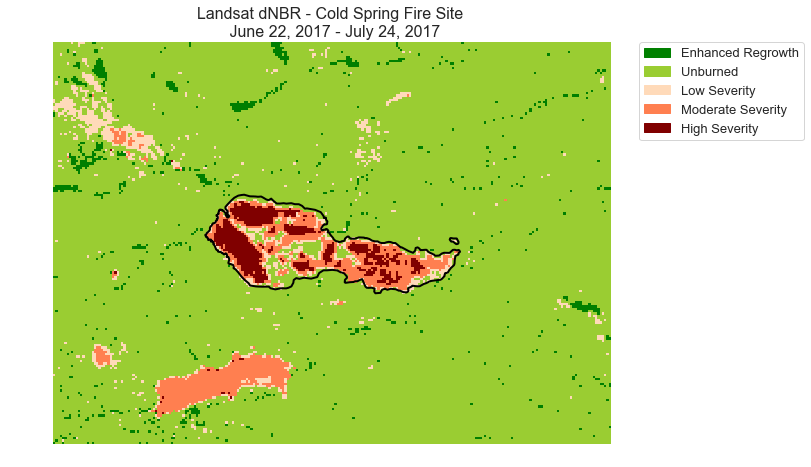

In [9]:
# Plot the data with a custom legend
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(dnbr_landsat_class,
               cmap=nbr_cmap,
               extent=landsat_extent)

fire_bound_utmz13.plot(ax=ax, color='None',
                       edgecolor='black',
                       linewidth=2)


values = np.unique(dnbr_landsat_class.ravel())

nbr_colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=nbr_colors[i],
                          label="{l}".format(l=dnbr_cat_names[i])) for i in range(len(dnbr_cat_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1),
           loc=2, borderaxespad=0.,
           prop={'size': 13})


ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
             fontsize=16)

# turn off ticks
ax.set_axis_off()
plt.show()

Alternatively you can create the legend with the earthpy. This function is still being tested but you can give it a try if you want!

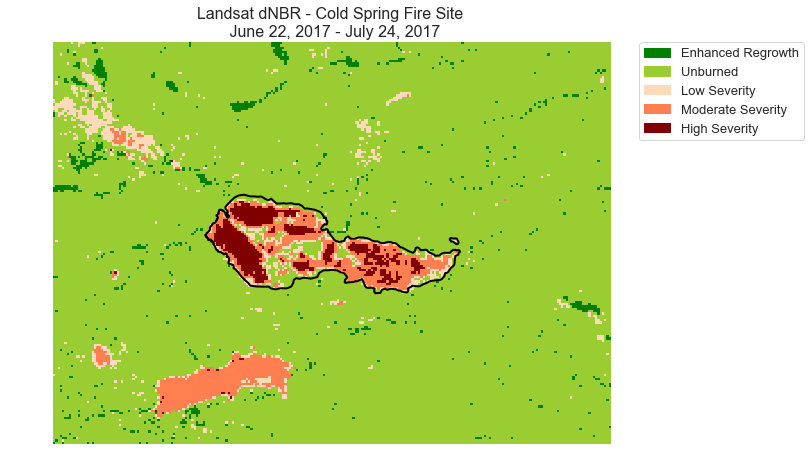

In [19]:
# Plot the data with a custom legend
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(dnbr_landsat_class,
               cmap=nbr_cmap,
               extent=landsat_extent)

fire_bound_utmz13.plot(ax=ax, color='None',
                       edgecolor='black',
                       linewidth=2)


values = np.unique(dnbr_landsat_class.ravel())

es.draw_legend(im, 
               classes=values,
               titles=dnbr_cat_names)


ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
             fontsize=16)

# turn off ticks
ax.set_axis_off()
plt.show()

### Create a Colorbar Legend

Alternatively you can create a discrete colorbar with labels. This method might be a bit less technical to follow. You can decide what type of legend you prefer for your homework. 

In [10]:
# Grab raster unique values (classes)
values = np.unique(dnbr_landsat_class).tolist()

# Add another index value because for n categories you need n+1 values to create bins
values = [0] + values

# Make a color map of fixed colors
nbr_colors = ["g", "yellowgreen", "peachpuff", "coral", "maroon"]
nbr_cmap = ListedColormap(nbr_colors)


# But the goal is the identify the MIDDLE point of each bin to create a centered tick
bounds = [((a + b) / 2) for a, b in zip(values[:-1], values[1::1])] + [5.5]

# Define normalization
norm = colors.BoundaryNorm(bounds, nbr_cmap.N)

Then, plot the data but this time add a colorbar rather than a custom legend.

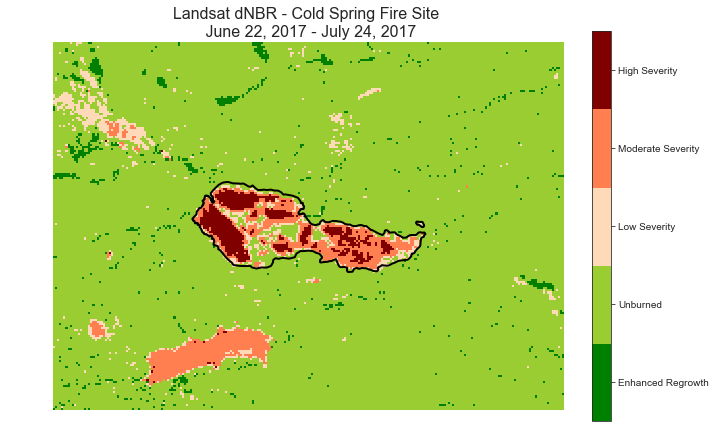

In [11]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(dnbr_landsat_class,
               cmap=nbr_cmap,
               extent=landsat_extent,
               norm=norm)

fire_bound_utmz13.plot(ax=ax,
                       color='None',
                       edgecolor='black',
                       linewidth=2)

cbar = fig.colorbar(im,
                    boundaries=bounds,
                    norm=norm,
                    fraction=.035)

cbar.set_ticks([np.unique(dnbr_landsat_class)])
cbar.set_ticklabels(dnbr_cat_names)
ax.set_title("Landsat dNBR - Cold Spring Fire Site \n June 22, 2017 - July 24, 2017",
             fontsize=16)

# turn off ticks
ax.set_axis_off()
plt.show()

### Histogram of dNBR values
A histogram of the data is useful to better understand the distribution. This is another optional element that you may just want to see how to do for future analysis! You will not need it for this week!

In [12]:
unique, counts = np.unique(dnbr_landsat_class.ravel(), return_counts=True)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(unique, counts,
       color="purple")

ax.set_title("Histogram of Landsat dNBR values - \nthis is not a homework plot. \nyou can use it to check your results if you want",
             fontsize=16)
ax.set_xticks(unique)
# get just the labels for unique values
dnbr_lab = [dnbr_cat_names[i] for i in unique]
ax.set_xticklabels(dnbr_lab)



## Calculate Total Area of Burned Area



Once you have classified your data, you can calculate the total burn area.

For this lesson, you are comparing the area calculated using modis that is "high severity" to that of Landsat.

You can calculate this using a loop, a function or manually - like so

```python
landsat_pixel = 30*30
burned_landsat = [dnbr_landsat_class[dnbr_landsat_class == 5].sum()]
burned_landsat = np.multiply(burned_landsat, landsat_pixel)
```




In [18]:
# To calculate area you'd multiple each bin by 30x30 to total square meters

landsat_pixel = 30*30
burned_landsat = [dnbr_landsat_class[dnbr_landsat_class == 5].sum()]
burned_landsat = np.multiply(burned_landsat, landsat_pixel)

print("Landsat Severe Burn Area:", burned_landsat)

Landsat Severe Burn Area: [3559500]
